In [3]:
import pandas as pd
import matplotlib.pyplot as plt

Top 100 Ether and Bitcoin balances obtained by Bart on June 4, 2020:

In [4]:
old_df = pd.read_csv('Barts_data.csv')
old_df

,ETH,BTC
0,3.785986e+06,255502.151153
1,3.125761e+06,176500.999634
2,2.507764e+06,111858.247990
3,2.358939e+06,94505.768824
4,1.378754e+06,89684.306228
...,...,...
95,1.500000e+05,10000.010407
96,1.500000e+05,10000.010261
97,1.500000e+05,10000.010243
98,1.500000e+05,10000.010243


The data about top 100 Ether balances for June 4, 2020 were obtainted using this query:
``` mysql
#standardSQL
DECLARE TARGET_DATE DATE;
SET TARGET_DATE = DATE("2020-06-05");
with double_entry_book as (
    -- debits
    select to_address as address, value as value
    from `bigquery-public-data.crypto_ethereum.traces`
    where to_address is not null
    and status = 1
    and value > 0
    and date(block_timestamp) < TARGET_DATE
    and (call_type not in ('delegatecall', 'callcode', 'staticcall') or call_type is null)
    union all -- combines results from different 'selects' with duplicates
    -- credits
    select from_address as address, -value as value
    from `bigquery-public-data.crypto_ethereum.traces`
    where from_address is not null
    and status = 1
    and value > 0
    and date(block_timestamp) < TARGET_DATE
    and (call_type not in ('delegatecall', 'callcode', 'staticcall') or call_type is null)
    union all
    -- transaction fees debits
    -- select miner as address, sum(cast(receipt_gas_used as numeric) * cast(gas_price as numeric)) as value
    select miner as address, sum(cast(receipt_gas_used as numeric) * cast((receipt_effective_gas_price - coalesce(base_fee_per_gas, 0)) as numeric)) as value
    from `bigquery-public-data.crypto_ethereum.transactions` as transactions
    join `bigquery-public-data.crypto_ethereum.blocks` as blocks on blocks.number = transactions.block_number
    group by blocks.miner
    union all
    -- transaction fees credits
    select from_address as address, -(cast(receipt_gas_used as numeric) * cast(gas_price as numeric)) as value
    from `bigquery-public-data.crypto_ethereum.transactions`
)
select address, sum(value) as balance
from double_entry_book
group by address
order by balance desc
limit 100
```

In [9]:
bq_eth_df = pd.read_csv('eth_2020-06-04.csv')
bq_eth_df['balance'] = bq_eth_df['balance'].astype(float)
bq_eth_df['balance'] /= 10**18  # convert Wei to Ether
bq_eth_df

,address,balance
0,0x742d35cc6634c0532925a3b844bc454e4438f44e,3.828379e+06
1,0xdc76cd25977e0a5ae17155770273ad58648900d3,3.125760e+06
2,0xbe0eb53f46cd790cd13851d5eff43d12404d33e8,2.507761e+06
3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,2.388548e+06
4,0x53d284357ec70ce289d6d64134dfac8e511c8a3d,1.378754e+06
...,...,...
95,0x7ae92148e79d60a0749fd6de374c8e81dfddf792,1.500000e+05
96,0xa0efb63be0db8fc11681a598bf351a42a6ff50e0,1.500000e+05
97,0xeddf8eb4984cc27407a568cae1c78a1ddb0c2c1b,1.500000e+05
98,0x19d599012788b991ff542f31208bab21ea38403e,1.500000e+05


The data about top 100 Bitcoin balances for June 4, 2020 were obtainted using the following query:
``` mysql
DECLARE TARGET_DATE DATE;
SET TARGET_DATE = DATE("2020-06-05");
WITH double_entry_book AS (
   -- debits
   SELECT array_to_string(inputs.addresses, ",") as address, inputs.type, -inputs.value as value
   FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
   WHERE DATE(inputs.block_timestamp) < TARGET_DATE
   UNION ALL
   -- credits
   SELECT array_to_string(outputs.addresses, ",") as address, outputs.type, outputs.value as value
   FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
   WHERE DATE(outputs.block_timestamp) < TARGET_DATE
)
SELECT address, type, sum(value) as balance
FROM double_entry_book
GROUP BY address, type
ORDER BY balance DESC
LIMIT 100
 
```

In [22]:
bq_btc_df = pd.read_csv('btc_2020-06-04.csv')
bq_btc_df['balance'] = bq_btc_df['balance'].astype(float)
bq_btc_df['balance'] /= 10**8  # convert Satoshi to BTC
bq_btc_df

,address,type,balance
0,35hK24tcLEWcgNA4JxpvbkNkoAcDGqQPsP,scripthash,255502.157659
1,3KZ526NxCVXbKwwP66RgM3pte6zW4gY1tD,scripthash,101857.247505
2,37XuVSEpWW4trkfmvWzegTHQt7BdktSKUs,scripthash,94505.772532
3,37do5d3pKeCuozjNCApGT153GJ8oNmKYbB,scripthash,88989.567185
4,1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF,pubkeyhash,79957.203510
...,...,...,...
95,bc1q2raxkmk55p000ggfa8euzs9fzq7p4cx4twycx7,witness_v0_keyhash,10000.010413
96,1BAFWQhH9pNkz3mZDQ1tWrtKkSHVCkc3fV,pubkeyhash,10000.010279
97,1ucXXZQSEf4zny2HRwAQKtVpkLPTUKRtt,pubkeyhash,10000.010261
98,1CPaziTqeEixPoSFtJxu74uDGbpEAotZom,pubkeyhash,10000.010255


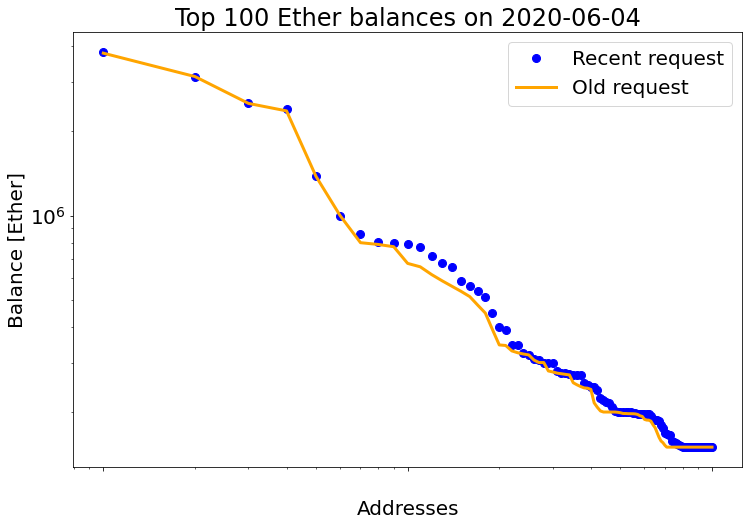

In [23]:
x = range(1, 101)
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(12, 8))
plt.xscale('log')
plt.yscale('log')
plt.title('Top 100 Ether balances on 2020-06-04')
plt.xlabel('Addresses')
plt.ylabel('Balance [Ether]')
plt.xticks(color='w')
plt.plot(x, bq_eth_df['balance'], marker='o', markersize='8', color='blue', linestyle='', label='Recent request')
plt.plot(x, old_df['ETH'], linestyle='-', linewidth=3, color='orange', label='Old request')
plt.legend()
plt.show()

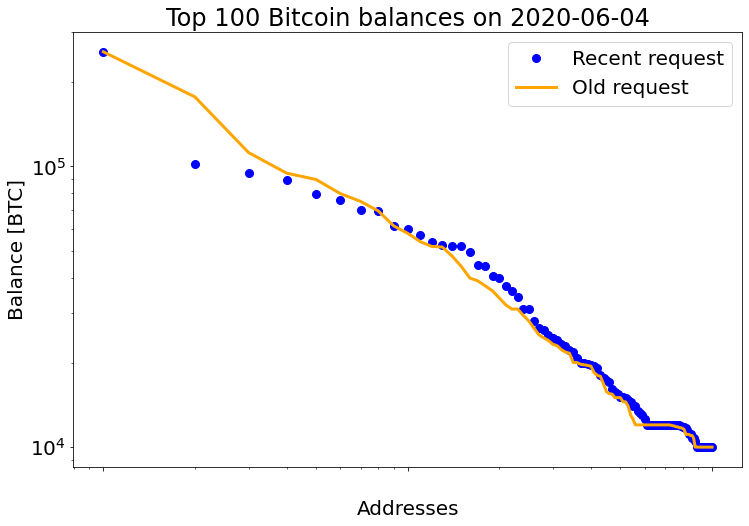

In [24]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(12, 8))
plt.xscale('log')
plt.yscale('log')
plt.title('Top 100 Bitcoin balances on 2020-06-04')
plt.xlabel('Addresses')
plt.ylabel('Balance [BTC]')
plt.xticks(color='w')
plt.plot(x, bq_btc_df['balance'], marker='o', markersize='8', color='blue', linestyle='', label='Recent request')
plt.plot(x, old_df['BTC'], linestyle='-', linewidth=3, color='orange', label='Old request')
plt.legend()
plt.show()